# Spotify Recommendation System Project

**Purpose:** Build a scalable music recommendation system using PySpark and Spotify datasets.

**Group members:**

* Raakin Bhatti
* Walid Farhat
* Long Nguyen
* Strahinja Radakovic

# Introduction

[placeholder for text]

**Relevance of Recommendation Systems:**
* Widely used in modern digital platforms to enhance user experience (e.g., Spotify, Netflix, Amazon).
* Help users discover relevant content, boosting engagement and satisfaction.

**Why Spotify Dataset?**
* Spotify is a leading music streaming platform with rich data on songs, artists, and user behavior.
* Provides an opportunity to explore user preferences and recommend songs or playlists.

**Big Data Challenge:**
* Music recommendation involves processing large volumes of data efficiently.
* PySpark is well-suited for handling and analyzing big data with its distributed computing capabilities.

**Goal of the Project:**
* Build a scalable recommendation system leveraging PySpark.
* Apply machine learning techniques to generate personalized music recommendations.

**Broader Applications:**
* Insights from the project can extend to other recommendation systems.
* Demonstrates the integration of big data tools and machine learning for real-world applications.


# Extracting dataset

We extracted the dataset from Spotify using Spotify API and the `Spotipy` library in Python.

Attached the Python files for extraction and transformation (from JSON to CSV).

# Setting up Spark

In [1]:
## OPTIONAL: Setting up Spark in Jupyter Notebook

# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
# !tar -xvf spark-3.5.3-bin-hadoop3.tgz
# !pip install findspark
# 
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"
# 
# import findspark
# findspark.init()
# findspark.find()

In [2]:
## OPTIONAL: Test if PySpark is ready to go

# from pyspark.sql import SparkSession
# 
# spark = SparkSession.builder.appName("Test").getOrCreate()
# print(f"Spark version:", spark.version)
# 
# spark.stop()

## expected result: 3.5.3 or similar

# Loading data

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
import pandas as pd
import matplotlib.pyplot as plt

# initialize a SparkSession
spark = SparkSession.builder \
    .appName("SpotifyRecommendationSystem") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# load dataset into a DataFrame
file_path = "./dataset/spotify_data.csv"
spotify_df = spark.read.csv(file_path, header=True, inferSchema=True)

# display the first few rows
spotify_df.show(5)


+---+-------------+----------------+--------------------+----------+----+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+
|_c0|  artist_name|      track_name|            track_id|popularity|year|   genre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|
+---+-------------+----------------+--------------------+----------+----+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+
|  0|   Jason Mraz| I Won't Give Up|53QF56cjZA9RTuuMZ...|        68|2012|acoustic|       0.483| 0.303|  4| -10.058|   1|     0.0429|       0.694|             0.0|   0.115|  0.139|133.406|   240166.0|           3.0|
|  1|   Jason Mraz|93 Million Miles|1s8tP3jP4GZcyHDsj...|        50|2012|acoustic|       0.572| 0.454|  3| -10.286|   1|     0.0258|       0

In [4]:
# print schema to verify column names and data types
spotify_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- year: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- time_signature: double (nullable = true)



### Quick summary:

Our group's recommendation system will use Content-Based Filtering method instead of Collaborative filtering. Content-Based Filtering method analyzes the audio characteristics of songs you’ve previously enjoyed, then the model will make personalized suggestions. We do not use Collaborative filtering or user-based filtering method becuase we cannot collect the information related to Spotify's users such as `user_id`.
   
The target variable you are modeling and potentially interesting features of the dataset you will be focusing on during the project. 

**Target variables:**

Based on this focus, we defined that the target variable is `track_id`, which means that we will recommend **tracks** based on their attributes.

**Features:**

We catogorized the features into corresponding groups as follows:

1. Key musical features:

* danceability: Indicates how suitable a track is for dancing.
* energy: Reflects the intensity and activity of the track.
* valence: Captures the musical positivity (happy/sad).
* tempo: The speed or pace of the track in beats per minute.

2. Categorical and context-based features:

* genre: Key for grouping similar tracks into clusters.
* year: Tracks trends and preferences over time.
* popularity: Acts as a secondary metric to boost recommendations for tracks that align with user preferences but are also well-received.

These features are not very important or relevant or already duplicated with other features above. So we might or might not use them for modelling depending on the performance and the needs for feature engineering. 

* acousticness: Degree of acoustic sound in the track.
* instrumentalness: Likelihood of the track being instrumental.
* liveness: Measures the presence of an audience in the track.
* loudness: Reflects the dynamic range and intensity.
* key and mode: Capture musical scale and tonality.
* time_signature: Represents the rhythm structure of the track.


# Preprocessing Data

**Data type conversins:**

From [Spotify's API documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) about track's audio features, each feature has its own meaning and data types. So we will convert the data types of features in our dataset to match Spotify's documentation.

In [5]:
# casting columns to their appropriate data types as per Spotify's documentation
spotify_df = spotify_df \
    .withColumn("popularity", col("popularity").cast("int")) \
    .withColumn("year", col("year").cast("int")) \
    .withColumn("danceability", col("danceability").cast("float")) \
    .withColumn("energy", col("energy").cast("float")) \
    .withColumn("key", col("key").cast("int")) \
    .withColumn("loudness", col("loudness").cast("float")) \
    .withColumn("mode", col("mode").cast("int")) \
    .withColumn("speechiness", col("speechiness").cast("float")) \
    .withColumn("acousticness", col("acousticness").cast("float")) \
    .withColumn("instrumentalness", col("instrumentalness").cast("float")) \
    .withColumn("liveness", col("liveness").cast("float")) \
    .withColumn("tempo", col("tempo").cast("float")) \
    .withColumn("time_signature", col("time_signature").cast("int"))

# re-check the updated schema
spotify_df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- time_signature: integer (nullable = true)



In [6]:
# Count total rows in the dataset
total_rows = spotify_df.count()
print(f"Total rows in the dataset: {total_rows}")

Total rows in the dataset: 1159764


In [7]:
# Display summary statistics for numerical columns
spotify_df.describe().show()

+-------+-----------------+-----------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+
|summary|              _c0|artist_name|          track_name|            track_id|        popularity|              year|             genre|     danceability|            energy|               key|          loudness|             mode|        speechiness|       acousticness|   instrumentalness|           liveness|            valence|             tempo|       duration_ms|    time_signature|
+-------+-----------------+-----------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+---------

**Check for missing values**

In [8]:
# Check for missing values in each column
missing_values = spotify_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in spotify_df.columns
])
missing_values.show()

+---+-----------+----------+--------+----------+----+-----+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+
|_c0|artist_name|track_name|track_id|popularity|year|genre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|
+---+-----------+----------+--------+----------+----+-----+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+
|  0|          0|         0|       0|      1673| 623|    0|        1184|   408|162|      94|  33|         16|           8|               3|       2|      0|    0|          0|             0|
+---+-----------+----------+--------+----------+----+-----+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+



**Distinct values**

Let's check the distinct values in the most important columns: `artist_name`, `track_name`, `genre`.

In [9]:
# Count distinct values in key columns
key_columns = ['artist_name', 'track_name', 'genre']
distinct_counts = {col_name: spotify_df.select(col_name).distinct().count() for col_name in key_columns}

for col_name, count in distinct_counts.items():
    print(f"Distinct values in {col_name}: {count}")

Distinct values in artist_name: 64159
Distinct values in track_name: 882285
Distinct values in genre: 392


Since `duration_ms` has no missing values, we will validate for unusual entries like negatives or extreme outliers in the dataset. For example, we will filter out the songs that have negativ or extremely long durations (> 10 minutes). Songs with negativ durations may mean corrupted data. Extremely long songs might need special handling (e.g. audiobooks or podcasts).

In [10]:
# Validate for negative or extremely high durations (e.g., > 10 minutes in milliseconds)
negative_durations = spotify_df.filter(col("duration_ms") < 0).count()
long_durations = spotify_df.filter(col("duration_ms") > 10 * 60 * 1000).count()

print(f"Number of negativ durations: {negative_durations}")
print(f"Number of extremely long durations (>10 minutes): {long_durations}")

Number of negativ durations: 3
Number of extremely long durations (>10 minutes): 15833


# Exploratory Data Analysis (EDA)

In this section, we will explore the dataset to find any patterns and correlations in the dataset. We will use some visualizations to show the trends and also validate the preprocessing in ealier steps.

Here are some tasks that we will perform:

* Check the distribution of numerical features.
* Correlation analysis.
* Analyze the popularity trends over year and by genre.
* Check the distribution by genre.
* Plot the relationship between enegery and danceability.
* Plot the relationship between valence and tempo.
* etc.

## Distribution of numerical features

In this section, we will check the distribution of important numerical features (e.g., popularity, danceability, tempo, valence) to understand data spread and skewness.

More info about each audio feature can be found in [Spotify's API documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-features).

Reasons to choose these numerical features:

* Popularity: This is a key metric for user preference and relevance. Tracks with higher popularity are more likely to be recommended.
* Danceability: This feature reflects how suitable a track is for dancing—an important factor in user satisfaction for genres like pop or electronic.
* Energy: This feature shows the intensity and activity level of a song, which can help classify songs by mood or genre (e.g., calm vs. energetic).
* Tempo: This is the speed of a song. THis is a key factor for many users when selecting playlists (e.g., playlists for workout, study, or relaxation).
* Valence: This indicates the emotional tone of the song (happy vs. sad), important for personalized recommendations based on mood. 
* Duration (`duration_ms`): This feature is relevant for filtering or grouping songs by length (e.g., short tracks for a quick playlist or long tracks for background music).

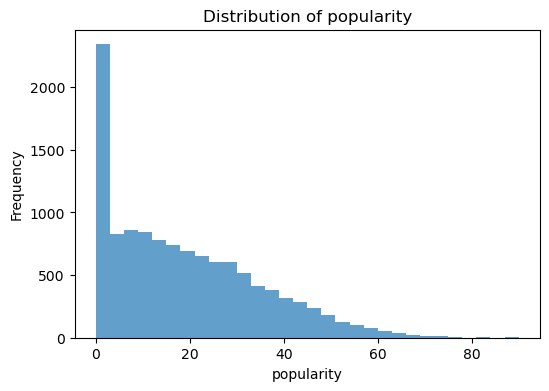

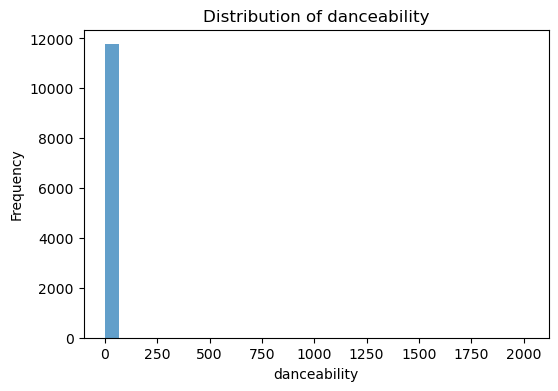

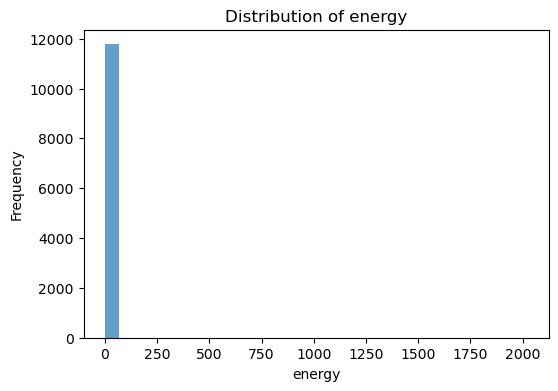

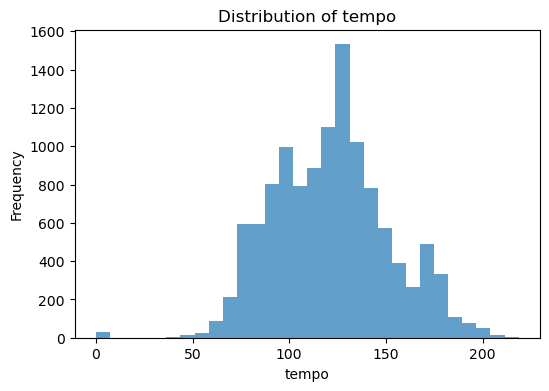

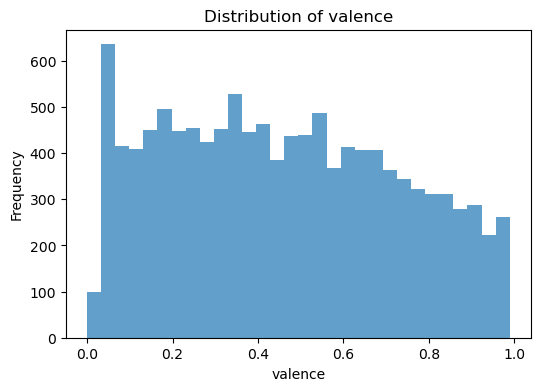

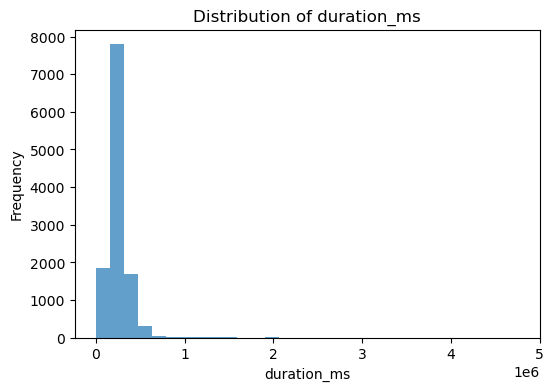

In [11]:
# Select numerical features to visualize
numerical_features = ["popularity", "danceability", "energy", "tempo", "valence", "duration_ms"]

# Convert PySpark DataFrame to Pandas for plotting
numerical_data = spotify_df.select(numerical_features).sample(fraction=0.01).toPandas()

# Plot histograms for each feature
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    plt.hist(numerical_data[feature].dropna(), bins=30, alpha=0.7)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

## Correlation analysis

In [13]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# Assemble features into a vector for correlation computation
vector_col = "features_vector"
assembler = VectorAssembler(inputCols=numerical_features, outputCol=vector_col)
spotify_df_vector = assembler.transform(spotify_df.select(numerical_features))

# Compute Pearson correlation matrix
correlation_matrix = Correlation.corr(spotify_df_vector, vector_col, "pearson").head()[0].toArray()

# Convert to Pandas DataFrame for easier visualization
correlation_df = pd.DataFrame(correlation_matrix, columns=numerical_features, index=numerical_features)
print("Correlation Matrix:")
print(correlation_df)

# Visualize the correlation matrix
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


Py4JJavaError: An error occurred while calling z:org.apache.spark.ml.stat.Correlation.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 41.0 failed 1 times, most recent failure: Lost task 1.0 in stage 41.0 (TID 259) (10.0.0.164 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4271/0x00000007c10fd828`: (struct<popularity_double_VectorAssembler_c5301569b7bd:double,danceability_double_VectorAssembler_c5301569b7bd:double,energy_double_VectorAssembler_c5301569b7bd:double,tempo_double_VectorAssembler_c5301569b7bd:double,valence:double,duration_ms:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 39 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1202)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1289)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1256)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1242)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1242)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeCovariance(RowMatrix.scala:456)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelationMatrix(PearsonCorrelation.scala:49)
	at org.apache.spark.mllib.stat.correlation.Correlations$.corrMatrix(Correlation.scala:66)
	at org.apache.spark.mllib.stat.Statistics$.corr(Statistics.scala:90)
	at org.apache.spark.ml.stat.Correlation$.corr(Correlation.scala:71)
	at org.apache.spark.ml.stat.Correlation.corr(Correlation.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4271/0x00000007c10fd828`: (struct<popularity_double_VectorAssembler_c5301569b7bd:double,danceability_double_VectorAssembler_c5301569b7bd:double,energy_double_VectorAssembler_c5301569b7bd:double,tempo_double_VectorAssembler_c5301569b7bd:double,valence:double,duration_ms:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 39 more
